In [1]:
pip install catboost


Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV, KFold
from sklearn.linear_model import LogisticRegression, LinearRegression, SGDRegressor
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier, RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.svm import LinearSVC, SVR
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import ConfusionMatrixDisplay, f1_score, make_scorer, confusion_matrix, mean_squared_error, mean_absolute_error

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

from xgboost import XGBClassifier, XGBRegressor
from catboost import CatBoostClassifier

from scipy.stats import randint, uniform

In [3]:
df = pd.read_csv('car_insurance_claim.csv')

In [4]:
df.head()

,ID,KIDSDRIV,BIRTH,AGE,HOMEKIDS,YOJ,INCOME,PARENT1,HOME_VAL,MSTATUS,...,CAR_TYPE,RED_CAR,OLDCLAIM,CLM_FREQ,REVOKED,MVR_PTS,CLM_AMT,CAR_AGE,CLAIM_FLAG,URBANICITY
0,63581743,0,16MAR39,60.0,0,11.0,"$67,349",No,$0,z_No,...,Minivan,yes,"$4,461",2,No,3,$0,18.0,0,Highly Urban/ Urban
1,132761049,0,21JAN56,43.0,0,11.0,"$91,449",No,"$257,252",z_No,...,Minivan,yes,$0,0,No,0,$0,1.0,0,Highly Urban/ Urban
2,921317019,0,18NOV51,48.0,0,11.0,"$52,881",No,$0,z_No,...,Van,yes,$0,0,No,2,$0,10.0,0,Highly Urban/ Urban
3,727598473,0,05MAR64,35.0,1,10.0,"$16,039",No,"$124,191",Yes,...,z_SUV,no,"$38,690",2,No,3,$0,10.0,0,Highly Urban/ Urban
4,450221861,0,05JUN48,51.0,0,14.0,NaN,No,"$306,251",Yes,...,Minivan,yes,$0,0,No,0,$0,6.0,0,Highly Urban/ Urban


# Basic Dat cleaning

In [5]:
df = df.copy()

In [6]:
df.columns

Index(['ID', 'KIDSDRIV', 'BIRTH', 'AGE', 'HOMEKIDS', 'YOJ', 'INCOME',
       'PARENT1', 'HOME_VAL', 'MSTATUS', 'GENDER', 'EDUCATION', 'OCCUPATION',
       'TRAVTIME', 'CAR_USE', 'BLUEBOOK', 'TIF', 'CAR_TYPE', 'RED_CAR',
       'OLDCLAIM', 'CLM_FREQ', 'REVOKED', 'MVR_PTS', 'CLM_AMT', 'CAR_AGE',
       'CLAIM_FLAG', 'URBANICITY'],
      dtype='object')

In [7]:
col_names = col_names = {
    'KIDSDRIV': 'num_young_drivers',
    'BIRTH': 'date_of_birth',
    'AGE': 'age',
    'HOMEKIDS': 'num_of_children',
    'YOJ': 'years_job_held_for',
    'INCOME': 'income',
    'PARENT1': 'single_parent',
    'HOME_VAL': 'value_of_home',
    'MSTATUS': 'married',
    'GENDER': 'gender',
    'EDUCATION': 'highest_education',
    'OCCUPATION': 'occupation',
    'TRAVTIME': 'commute_dist',
    'CAR_USE': 'type_of_use',
    'BLUEBOOK': 'vehicle_value',
    'TIF': 'policy_tenure',
    'CAR_TYPE': 'vehicle_type',
    'RED_CAR': 'red_vehicle',
    'OLDCLAIM': '5_year_total_claims_value',
    'CLM_FREQ': '5_year_num_of_claims',
    'REVOKED': 'licence_revoked',
    'MVR_PTS': 'license_points',
    'CLM_AMT': 'new_claim_value',
    'CAR_AGE': 'vehicle_age',
    'CLAIM_FLAG': 'is_claim',
    'URBANICITY': 'address_type'
}

df.rename(columns = col_names, inplace = True)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10302 entries, 0 to 10301
Data columns (total 27 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   ID                         10302 non-null  int64  
 1   num_young_drivers          10302 non-null  int64  
 2   date_of_birth              10302 non-null  object 
 3   age                        10295 non-null  float64
 4   num_of_children            10302 non-null  int64  
 5   years_job_held_for         9754 non-null   float64
 6   income                     9732 non-null   object 
 7   single_parent              10302 non-null  object 
 8   value_of_home              9727 non-null   object 
 9   married                    10302 non-null  object 
 10  gender                     10302 non-null  object 
 11  highest_education          10302 non-null  object 
 12  occupation                 9637 non-null   object 
 13  commute_dist               10302 non-null  int

In [9]:
df.duplicated().sum()

1

In [10]:
# Drop duplicates

In [11]:
df.drop_duplicates(inplace = True)

In [12]:
# Define currency based columns
currency_cols = ['income', 'value_of_home', 'vehicle_value', '5_year_total_claims_value', 'new_claim_value']

# Create function to remove '$' and ','
def format_currency_cols(data, cols):
    for col in cols:
        data[col] = data[col].replace('[\\$,]', '', regex=True).astype('Int64')
    return data

df = format_currency_cols(df, currency_cols)

In [13]:
z_prefix_cols = ['married', 'gender', 'highest_education', 'occupation', 'vehicle_type', 'address_type']

# Create function to remove 'z_' prefix
def remove_prefix(data, cols):
    for col in cols:
        data[col] = data[col].replace('[z_]', '', regex=True)
    return data

df = remove_prefix(df, z_prefix_cols)

In [14]:
df.drop(['ID', 'date_of_birth'], axis=1, inplace=True)

In [15]:
df.head()

,num_young_drivers,age,num_of_children,years_job_held_for,income,single_parent,value_of_home,married,gender,highest_education,...,vehicle_type,red_vehicle,5_year_total_claims_value,5_year_num_of_claims,licence_revoked,license_points,new_claim_value,vehicle_age,is_claim,address_type
0,0,60.0,0,11.0,67349,No,0,No,M,PhD,...,Minivan,yes,4461,2,No,3,0,18.0,0,Highly Urban/ Urban
1,0,43.0,0,11.0,91449,No,257252,No,M,High School,...,Minivan,yes,0,0,No,0,0,1.0,0,Highly Urban/ Urban
2,0,48.0,0,11.0,52881,No,0,No,M,Bachelors,...,Van,yes,0,0,No,2,0,10.0,0,Highly Urban/ Urban
3,0,35.0,1,10.0,16039,No,124191,Yes,F,High School,...,SUV,no,38690,2,No,3,0,10.0,0,Highly Urban/ Urban
4,0,51.0,0,14.0,<NA>,No,306251,Yes,M,<High School,...,Minivan,yes,0,0,No,0,0,6.0,0,Highly Urban/ Urban


In [16]:
# create Trian/ Test split

In [17]:
mask = (df['new_claim_value'] > 0) & (df['is_claim'] == 0)
df[mask]

,num_young_drivers,age,num_of_children,years_job_held_for,income,single_parent,value_of_home,married,gender,highest_education,...,vehicle_type,red_vehicle,5_year_total_claims_value,5_year_num_of_claims,licence_revoked,license_points,new_claim_value,vehicle_age,is_claim,address_type


<Axes: xlabel='new_claim_value', ylabel='Count'>

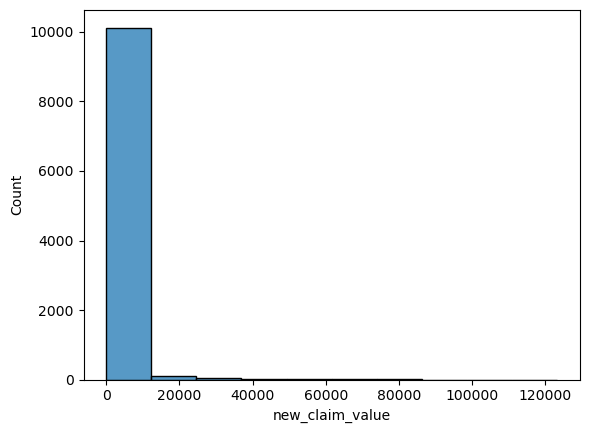

In [18]:
sns.histplot(df['new_claim_value'],bins =10)

In [19]:
bins = [0.0, 5000, 10_000, 15_000, 20_000, 25_000, 30_000, 35_000, 40_000, 45_000, 50_000, np.inf]
# define bin labels
labels = np.arange(1,12)
# Apply the bins using cut
df['claim_value_cat'] = pd.cut(df['new_claim_value'], bins, labels=labels, include_lowest =True)

<Axes: ylabel='claim_value_cat'>

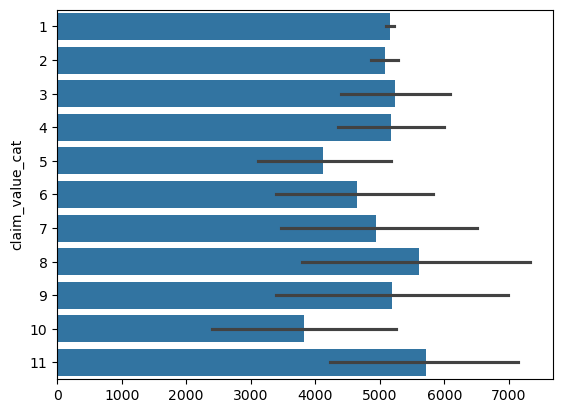

In [20]:
sns.barplot(df['claim_value_cat'])

In [21]:
# create clean copy of training data 
X =df.copy()
y = df['is_claim']

# Drop the target features
X.drop(columns = ['new_claim_value', 'is_claim'], inplace=True)

#Create train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=X['claim_value_cat'])

In [22]:
train_ratio = round((y_train.sum()/len(y_train))*100,2)
test_ratio = round((y_test.sum()/len(y_test)*100),2)
print(f'Train positive class ratio: {train_ratio}%')
print(f' Test positive class ratio: {test_ratio}%')

Train positive class ratio: 26.48%
 Test positive class ratio: 27.37%


In [23]:

for set_ in (X_train, X_test):
    set_.drop(columns=['claim_value_cat'], inplace=True)

# EDA

In [24]:
# Preparation of our EDA, We'll join X_train and y_trin so we can investigate correlation

In [25]:
# Create a new copy of X_train for the analysis
eda_test_data = X_train.copy()
eda_test_data['is_claim'] = y_train

In [26]:
binary_cols = ['single_parent', 'married', 'gender', 'red_vechile', 'licence_revoked']

# Define map values
mapping = {'yes': 1,
           'No': 0,
           'yes': 1,
           'no': 0,
           'M': 1,
           'F': 0,
          }

#define function to bimarise features
def binarise_values(data, cols, map):
    for col in cols:
        data[col] = data[col].map(map)
        return data

#call function
eda_test_data = binarise_values(eda_test_data, binary_cols, mapping)


In [27]:
# check updated values
eda_test_data.head()

,num_young_drivers,age,num_of_children,years_job_held_for,income,single_parent,value_of_home,married,gender,highest_education,...,policy_tenure,vehicle_type,red_vehicle,5_year_total_claims_value,5_year_num_of_claims,licence_revoked,license_points,vehicle_age,address_type,is_claim
8452,0,57.0,0,NaN,33707,0.0,0,No,F,<High School,...,10,SUV,no,0,0,No,1,1.0,Highly Rural/ Rural,0
7822,2,41.0,3,14.0,17321,0.0,109835,Yes,F,<High School,...,4,Sports Car,no,0,0,No,3,1.0,Highly Urban/ Urban,0
1312,0,29.0,2,12.0,54310,NaN,174139,No,M,<High School,...,4,Minivan,no,5419,1,No,5,6.0,Highly Urban/ Urban,1
921,0,46.0,1,13.0,62886,NaN,202178,No,F,Bachelors,...,1,Minivan,no,5290,1,No,6,6.0,Highly Urban/ Urban,0
8708,0,39.0,0,8.0,115182,0.0,312887,Yes,M,High School,...,1,Pickup,no,0,0,No,1,5.0,Highly Urban/ Urban,0


In [28]:
# Corre;ation matrix

In [29]:
eda_test_data.corr(numeric_only=True).sort_values(by = 'is_claim', ascending=False)

,num_young_drivers,age,num_of_children,years_job_held_for,income,single_parent,value_of_home,commute_dist,vehicle_value,policy_tenure,5_year_total_claims_value,5_year_num_of_claims,license_points,vehicle_age,is_claim
is_claim,0.109085,-0.107146,0.128697,-0.053815,-0.147085,NaN,-0.193881,0.044019,-0.103979,-0.082839,0.147094,0.224952,0.218605,-0.113344,1.000000
5_year_num_of_claims,0.034724,-0.037820,0.038404,-0.026019,-0.044323,NaN,-0.092703,0.006396,-0.034264,-0.015396,0.491048,1.000000,0.403083,-0.023960,0.224952
license_points,0.052874,-0.079780,0.071365,-0.040719,-0.065223,NaN,-0.097057,0.006975,-0.053148,-0.032602,0.267866,0.403083,1.000000,-0.035502,0.218605
5_year_total_claims_value,0.035981,-0.040818,0.049397,-0.005708,-0.049042,NaN,-0.067330,-0.017241,-0.030692,-0.012395,1.000000,0.491048,0.267866,-0.031716,0.147094
num_of_children,0.461488,-0.448207,1.000000,0.079570,-0.158150,NaN,-0.106974,-0.000621,-0.109210,0.012882,0.049397,0.038404,0.071365,-0.152561,0.128697
num_young_drivers,1.000000,-0.076813,0.461488,0.038082,-0.046508,NaN,-0.022470,0.012918,-0.026245,-0.004106,0.035981,0.034724,0.052874,-0.062621,0.109085
commute_dist,0.012918,0.003201,-0.000621,-0.008878,-0.051479,NaN,-0.031111,1.000000,-0.024179,-0.002833,-0.017241,0.006396,0.006975,-0.037156,0.044019
years_job_held_for,0.038082,0.134522,0.079570,1.000000,0.294414,NaN,0.266811,-0.008878,0.144719,0.023089,-0.005708,-0.026019,-0.040719,0.053936,-0.053815
policy_tenure,-0.004106,-0.004511,0.012882,0.023089,0.003469,NaN,0.011225,-0.002833,0.001760,1.000000,-0.012395,-0.015396,-0.032602,0.004632,-0.082839
vehicle_value,-0.026245,0.172433,-0.109210,0.144719,0.426426,NaN,0.257783,-0.024179,1.000000,0.001760,-0.030692,-0.034264,-0.053148,0.191458,-0.103979


<Axes: >

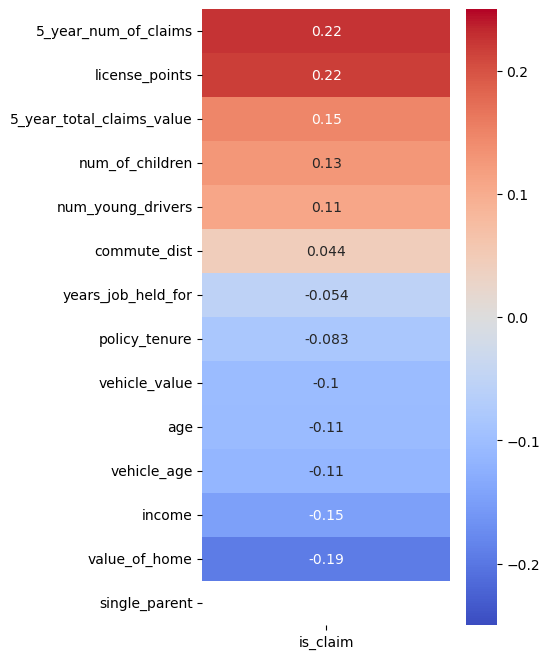

In [30]:
fig, ax = plt.subplots(figsize=(4, 8))
corr_matrix = eda_test_data.corr(numeric_only=True).sort_values(by='is_claim', ascending=False)
corr_matrix_no_claim = corr_matrix.drop('is_claim')
sns.heatmap(corr_matrix_no_claim[['is_claim']],cmap ='coolwarm', annot=True, vmax=0.25, vmin=-0.25)

In [31]:
# Data cleaning and preprocessing

In [32]:
X_train_raw = X_train.copy()

cols_to_drop = [
    'red_vehicle',
]

X_train_raw.drop(columns=cols_to_drop, axis=1, inplace=True)

# Handling Missing values

In [33]:
# Check the number of missing values in each row 
X_train_raw.isnull().sum()

num_young_drivers              0
age                            5
num_of_children                0
years_job_held_for           433
income                       474
single_parent                  0
value_of_home                462
married                        0
gender                         0
highest_education              0
occupation                   527
commute_dist                   0
type_of_use                    0
vehicle_value                  0
policy_tenure                  0
vehicle_type                   0
5_year_total_claims_value      0
5_year_num_of_claims           0
licence_revoked                0
license_points                 0
vehicle_age                  517
address_type                   0
dtype: int64

In [34]:
X_train_raw.isnull().sum()

num_young_drivers              0
age                            5
num_of_children                0
years_job_held_for           433
income                       474
single_parent                  0
value_of_home                462
married                        0
gender                         0
highest_education              0
occupation                   527
commute_dist                   0
type_of_use                    0
vehicle_value                  0
policy_tenure                  0
vehicle_type                   0
5_year_total_claims_value      0
5_year_num_of_claims           0
licence_revoked                0
license_points                 0
vehicle_age                  517
address_type                   0
dtype: int64

In [35]:

# Create the imputer
knn_imputer = KNNImputer(n_neighbors=2)

# Define the numerical columns
numerical_cols_df = X_train_raw.select_dtypes(include=['number'])
numerical_cols = numerical_cols_df.columns.tolist()

# Define the categorial columns for use later
cat_cols_df = X_train_raw.select_dtypes(include=['object'])
cat_cols = cat_cols_df.columns.tolist()

In [36]:
# Define function to impute num features using KNN
def num_knn_impute(data, cols, imputer):
    data = data[cols]
    data_imputed = pd.DataFrame(imputer.fit_transform(data))
    data_imputed.columns = data.columns
    return data_imputed

# Run the function to impute numerical values with knn
num_test_data_imputed = num_knn_impute(X_train_raw, numerical_cols, knn_imputer)

In [37]:
# Get numerical cols as a df
num_cols_df = X_train_raw[numerical_cols].reset_index(drop=True)
# Select rows with missing values and show head
missing_data_df = num_cols_df[num_cols_df.isna().any(axis=1)]
missing_data_df.head()

,num_young_drivers,age,num_of_children,years_job_held_for,income,value_of_home,commute_dist,vehicle_value,policy_tenure,5_year_total_claims_value,5_year_num_of_claims,license_points,vehicle_age
0,0,57.0,0,NaN,33707,0,40,7200,10,0,0,1,1.0
11,0,36.0,2,13.0,19934,<NA>,17,10790,6,7797,2,9,1.0
19,0,59.0,0,11.0,123969,347418,35,31540,1,0,0,1,NaN
25,0,51.0,0,7.0,141546,351285,18,29330,4,1184,2,4,NaN
28,1,51.0,1,8.0,<NA>,253662,5,12430,1,9000,1,0,11.0


In [38]:

# Show same records after imputation
samples = missing_data_df.index.to_list()
num_test_data_imputed.loc[samples].head()

,num_young_drivers,age,num_of_children,years_job_held_for,income,value_of_home,commute_dist,vehicle_value,policy_tenure,5_year_total_claims_value,5_year_num_of_claims,license_points,vehicle_age
0,0.0,57.0,0.0,0.0,33707.0,0.0,40.0,7200.0,10.0,0.0,0.0,1.0,1.0
11,0.0,36.0,2.0,13.0,19934.0,158778.5,17.0,10790.0,6.0,7797.0,2.0,9.0,1.0
19,0.0,59.0,0.0,11.0,123969.0,347418.0,35.0,31540.0,1.0,0.0,0.0,1.0,8.5
25,0.0,51.0,0.0,7.0,141546.0,351285.0,18.0,29330.0,4.0,1184.0,2.0,4.0,7.0
28,1.0,51.0,1.0,8.0,67333.0,253662.0,5.0,12430.0,1.0,9000.0,1.0,0.0,11.0


In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [40]:
# 1. Identify categorical columns
cat_columns = X_test.select_dtypes(include=['object', 'category']).columns

# 2. Extract categorical test data
cat_test_data = X_test[cat_columns]

# 3. Impute missing values
from sklearn.impute import SimpleImputer
cat_imputer = SimpleImputer(strategy="most_frequent")
cat_test_data_imputed = pd.DataFrame(
    cat_imputer.fit_transform(cat_test_data),
    columns=cat_test_data.columns
)


In [41]:

# Rejoin dfs
train_imputed_df = pd.concat([num_test_data_imputed, cat_test_data_imputed], axis=1)
# Check head
train_imputed_df.head()

,num_young_drivers,age,num_of_children,years_job_held_for,income,value_of_home,commute_dist,vehicle_value,policy_tenure,5_year_total_claims_value,...,married,gender,highest_education,occupation,type_of_use,vehicle_type,red_vehicle,licence_revoked,address_type,claim_value_cat
0,0.0,57.0,0.0,0.0,33707.0,0.0,40.0,7200.0,10.0,0.0,...,Yes,M,High School,Professional,Private,Van,yes,No,Highly Urban/ Urban,1
1,2.0,41.0,3.0,14.0,17321.0,109835.0,24.0,6530.0,4.0,0.0,...,No,F,High School,Professional,Private,SUV,no,No,Highly Urban/ Urban,1
2,0.0,29.0,2.0,12.0,54310.0,174139.0,39.0,1500.0,4.0,5419.0,...,Yes,M,<High School,Clerical,Commercial,Pickup,yes,No,Highly Urban/ Urban,2
3,0.0,46.0,1.0,13.0,62886.0,202178.0,18.0,22260.0,1.0,5290.0,...,No,F,High School,Home Maker,Private,SUV,no,No,Highly Rural/ Rural,1
4,0.0,39.0,0.0,8.0,115182.0,312887.0,25.0,5400.0,1.0,0.0,...,No,F,High School,Home Maker,Private,Sports Car,no,No,Highly Urban/ Urban,1


In [42]:

train_imputed_df.isnull().sum()

num_young_drivers               0
age                             0
num_of_children                 0
years_job_held_for              0
income                          0
value_of_home                   0
commute_dist                    0
vehicle_value                   0
policy_tenure                   0
5_year_total_claims_value       0
5_year_num_of_claims            0
license_points                  0
vehicle_age                     0
single_parent                6179
married                      6179
gender                       6179
highest_education            6179
occupation                   6179
type_of_use                  6179
vehicle_type                 6179
red_vehicle                  6179
licence_revoked              6179
address_type                 6179
claim_value_cat              6179
dtype: int64

# 3.4. Categorical Feature Encoding

In [43]:
cat_test_data_imputed.nunique()

single_parent         2
married               2
gender                2
highest_education     5
occupation            8
type_of_use           2
vehicle_type          6
red_vehicle           2
licence_revoked       2
address_type          2
claim_value_cat      10
dtype: int64

In [44]:
Cat_cols_ord = ['highest_education']
#Define binary features
cat_cols_bin = ['single_parent', 'married', 'gender', 'type_of_use', ' licence_revoked', ' address_type']
#define one-hot features
cat_cols_one_hot = ['occupation', ' vehicle_type']

In [45]:
print(cat_test_data_imputed.columns)


Index(['single_parent', 'married', 'gender', 'highest_education', 'occupation',
       'type_of_use', 'vehicle_type', 'red_vehicle', 'licence_revoked',
       'address_type', 'claim_value_cat'],
      dtype='object')


#We can now create the encoders for each feature type. For the education encoder we will first need to define the order/ranking of the levels of education.

In [46]:
education_rank = [['High School', 'Bachelors', 'Masters', 'PhD']]

# Define ordinal encoder

ord_encoder = OrdinalEncoder(categories = education_rank)

# Define binay encoder
bin_encoder = OrdinalEncoder()
# Define one-host encoder
one_host_encoder = OneHotEncoder(handle_unknown = 'ignore', sparse_output=False)


In [47]:
# Example split – you need to adapt these to your dataset
cat_cols_ord = ["EducationLevel", "SatisfactionLevel"]   # ordinal columns
cat_cols_bin = ["Gender", "YesNoColumn"]                 # binary columns
cat_cols_one_hot = ["City", "Department"]                # nominal columns


In [48]:
# Install if not installed
!pip install category_encoders


In [49]:
!pip install --upgrade category_encoders


In [50]:
# Define ordinal features
cat_cols_ord = ['highest_education']
# Define binary features
cat_cols_bin = ['single_parent', 'married', 'gender', 'type_of_use', 'licence_revoked', 'address_type']
# Define one-hot features
cat_cols_one_hot = ['occupation', 'vehicle_type']

In [51]:

education_rank = [['<High School', 'High School', 'Bachelors', 'Masters', 'PhD']]

# Define ordinal encoder
ord_encoder = OrdinalEncoder(categories=education_rank)

# Define binary encoder
bin_encoder = OrdinalEncoder()

# Define one-host encoder
one_hot_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

In [52]:
# Encode ordinals
ord_encoded = ord_encoder.fit_transform(cat_test_data_imputed[cat_cols_ord])

# Encode binaries
bin_encoded = bin_encoder.fit_transform(cat_test_data_imputed[cat_cols_bin])

# One-hot encoding
one_hot_encoded = one_hot_encoder.fit_transform(cat_test_data_imputed[cat_cols_one_hot])

In [53]:
# Create dfs for each array
ord_encoded_df = pd.DataFrame(ord_encoded)
ord_encoded_df.columns = cat_cols_ord

bin_encoded_df = pd.DataFrame(bin_encoded)
bin_encoded_df.columns = cat_cols_bin

one_hot_encoded_df = pd.DataFrame(one_hot_encoded)
one_hot_encoded_df.columns = one_hot_encoder.get_feature_names_out()

# Join encoded dfs to a single df and show head
all_cat_encoded_df = pd.concat([ord_encoded_df, bin_encoded_df, one_hot_encoded_df], axis=1)
all_cat_encoded_df.head()

,highest_education,single_parent,married,gender,type_of_use,licence_revoked,address_type,occupation_Blue Collar,occupation_Clerical,occupation_Doctor,...,occupation_Lawyer,occupation_Manager,occupation_Professional,occupation_Student,vehicle_type_Minivan,vehicle_type_Panel Truck,vehicle_type_Pickup,vehicle_type_SUV,vehicle_type_Sports Car,vehicle_type_Van
0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [54]:
X_train_cleaned = pd.concat([train_imputed_df[numerical_cols], all_cat_encoded_df], axis=1)

In [55]:
#c check df
X_train_cleaned.head()

,num_young_drivers,age,num_of_children,years_job_held_for,income,value_of_home,commute_dist,vehicle_value,policy_tenure,5_year_total_claims_value,...,occupation_Lawyer,occupation_Manager,occupation_Professional,occupation_Student,vehicle_type_Minivan,vehicle_type_Panel Truck,vehicle_type_Pickup,vehicle_type_SUV,vehicle_type_Sports Car,vehicle_type_Van
0,0.0,57.0,0.0,0.0,33707.0,0.0,40.0,7200.0,10.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,2.0,41.0,3.0,14.0,17321.0,109835.0,24.0,6530.0,4.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,29.0,2.0,12.0,54310.0,174139.0,39.0,1500.0,4.0,5419.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.0,46.0,1.0,13.0,62886.0,202178.0,18.0,22260.0,1.0,5290.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,39.0,0.0,8.0,115182.0,312887.0,25.0,5400.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [56]:
import numpy as np
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# ---- STEP 1: Function to calculate VIF ----
def calculate_vif(dataframe):
    # Ensure all values are numeric
    df_numeric = dataframe.select_dtypes(include=[np.number])

    # Replace inf/-inf with NaN
    df_numeric = df_numeric.replace([np.inf, -np.inf], np.nan)

    # Drop rows with NaN
    df_numeric = df_numeric.dropna()

    # Add constant for intercept
    df_with_constant = add_constant(df_numeric)

    # Calculate VIF
    vif_data = pd.DataFrame()
    vif_data["Feature"] = df_with_constant.columns
    vif_data["VIF"] = [
        variance_inflation_factor(df_with_constant.values, i)
        for i in range(df_with_constant.shape[1])
    ]
    return vif_data

# ---- STEP 2: Run on your encoded data ----
vif_df = calculate_vif(X_train_cleaned)
print(vif_df)


C:\Users\arjun\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1783: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


                      Feature       VIF
0                       const  0.000000
1           num_young_drivers  1.337843
2                         age  1.404230
3             num_of_children  1.720835
4          years_job_held_for  1.160998
5                      income  1.885108
6               value_of_home  1.475037
7                commute_dist  1.018917
8               vehicle_value  1.279704
9               policy_tenure  1.014623
10  5_year_total_claims_value  1.340708
11       5_year_num_of_claims  1.540321
12             license_points  1.232624
13                vehicle_age  1.189743
14          highest_education  1.842685
15              single_parent  1.327711
16                    married  1.302869
17                     gender  2.265308
18                type_of_use  2.312590
19            licence_revoked  1.026618
20               address_type  1.111292
21     occupation_Blue Collar       inf
22        occupation_Clerical       inf
23          occupation_Doctor       inf


C:\Users\arjun\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


In [57]:
X_train_cleaned.drop(['occupation_Blue Collar' ,'vehicle_type_Minivan'], axis=1, inplace=True)

In [58]:
# Calculate VIF for encoded data
vif_df = calculate_vif(X_train_cleaned)
vif_df

,Feature,VIF
0,const,73.906727
1,num_young_drivers,1.337843
2,age,1.404230
3,num_of_children,1.720835
4,years_job_held_for,1.160998
5,income,1.885108
6,value_of_home,1.475037
7,commute_dist,1.018917
8,vehicle_value,1.279704
9,policy_tenure,1.014623


In [59]:
# Model Selection- classfication

In [60]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier
)
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

clfs = [
    ('Logistic Regression', LogisticRegression(solver='liblinear', max_iter=2000)),
    ('KNN', KNeighborsClassifier()),
    ('Decision Tree', DecisionTreeClassifier(random_state=42)),
    ('Random Forest', RandomForestClassifier(random_state=42)),
    ('Linear SVM', LinearSVC(random_state=42, max_iter=1000, dual='auto')),
    ('XGBoost', XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')),
    ('AdaBoost', AdaBoostClassifier(random_state=42, algorithm='SAMME')),
    ('Gradient Boost', GradientBoostingClassifier(random_state=42)),
    ('Bagging', BaggingClassifier(random_state=42)),
    ('CatBoost', CatBoostClassifier(random_state=42, verbose=0)),
]


In [61]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="most_frequent")  # or "mean" for numeric only
X_train_imputed = pd.DataFrame(
    imputer.fit_transform(X_train_cleaned),
    columns=X_train_cleaned.columns
)


In [62]:
from sklearn.model_selection import KFold

# Create KFold object with 10 folds
kf = KFold(n_splits=10, shuffle=True, random_state=42)


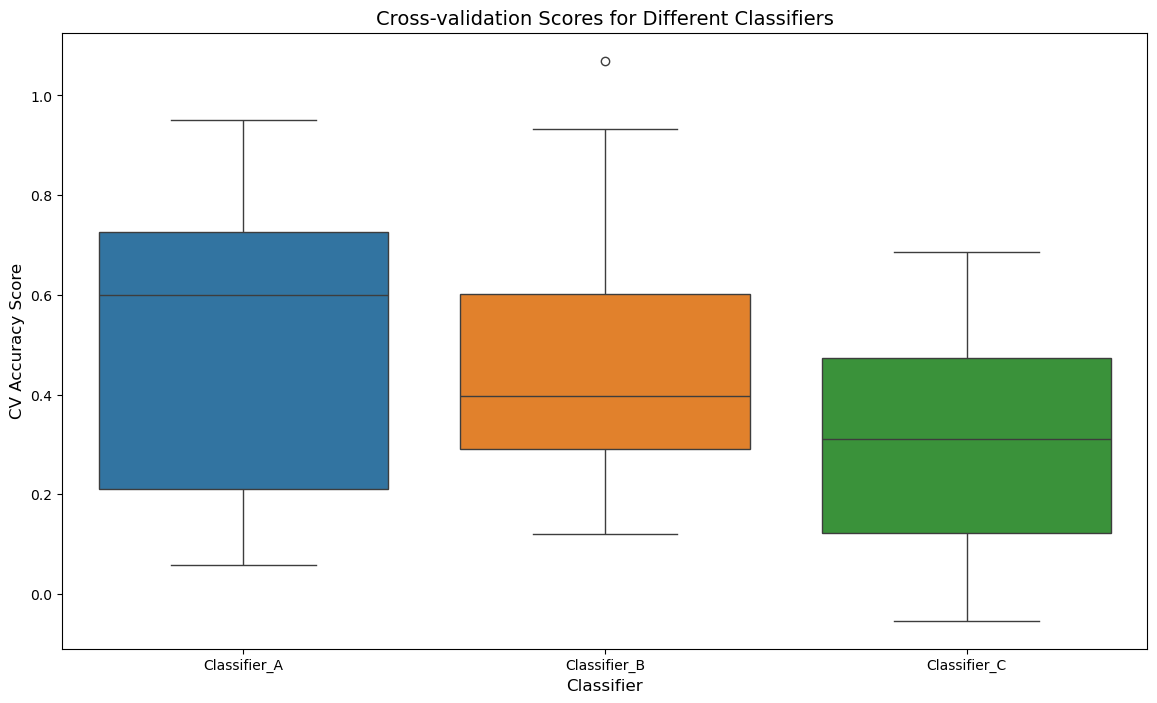

In [63]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Create some sample data for demonstration
np.random.seed(42)
data = {
    'Classifier_A': np.random.rand(10),
    'Classifier_B': np.random.rand(10) + 0.1,
    'Classifier_C': np.random.rand(10) - 0.1
}
cv_scores_df = pd.DataFrame(data)

# --- Your Code with Correction ---
fig, ax = plt.subplots(figsize=(14,8))
sns.boxplot(data=cv_scores_df, ax=ax) # It's good practice to pass the axes object to seaborn

# Add axis labels
ax.set_xlabel('Classifier', fontsize=12)
ax.set_ylabel('CV Accuracy Score', fontsize=12) # Corrected line
ax.set_title('Cross-validation Scores for Different Classifiers', fontsize=14)

plt.show()

In [64]:
#Feature Engineering

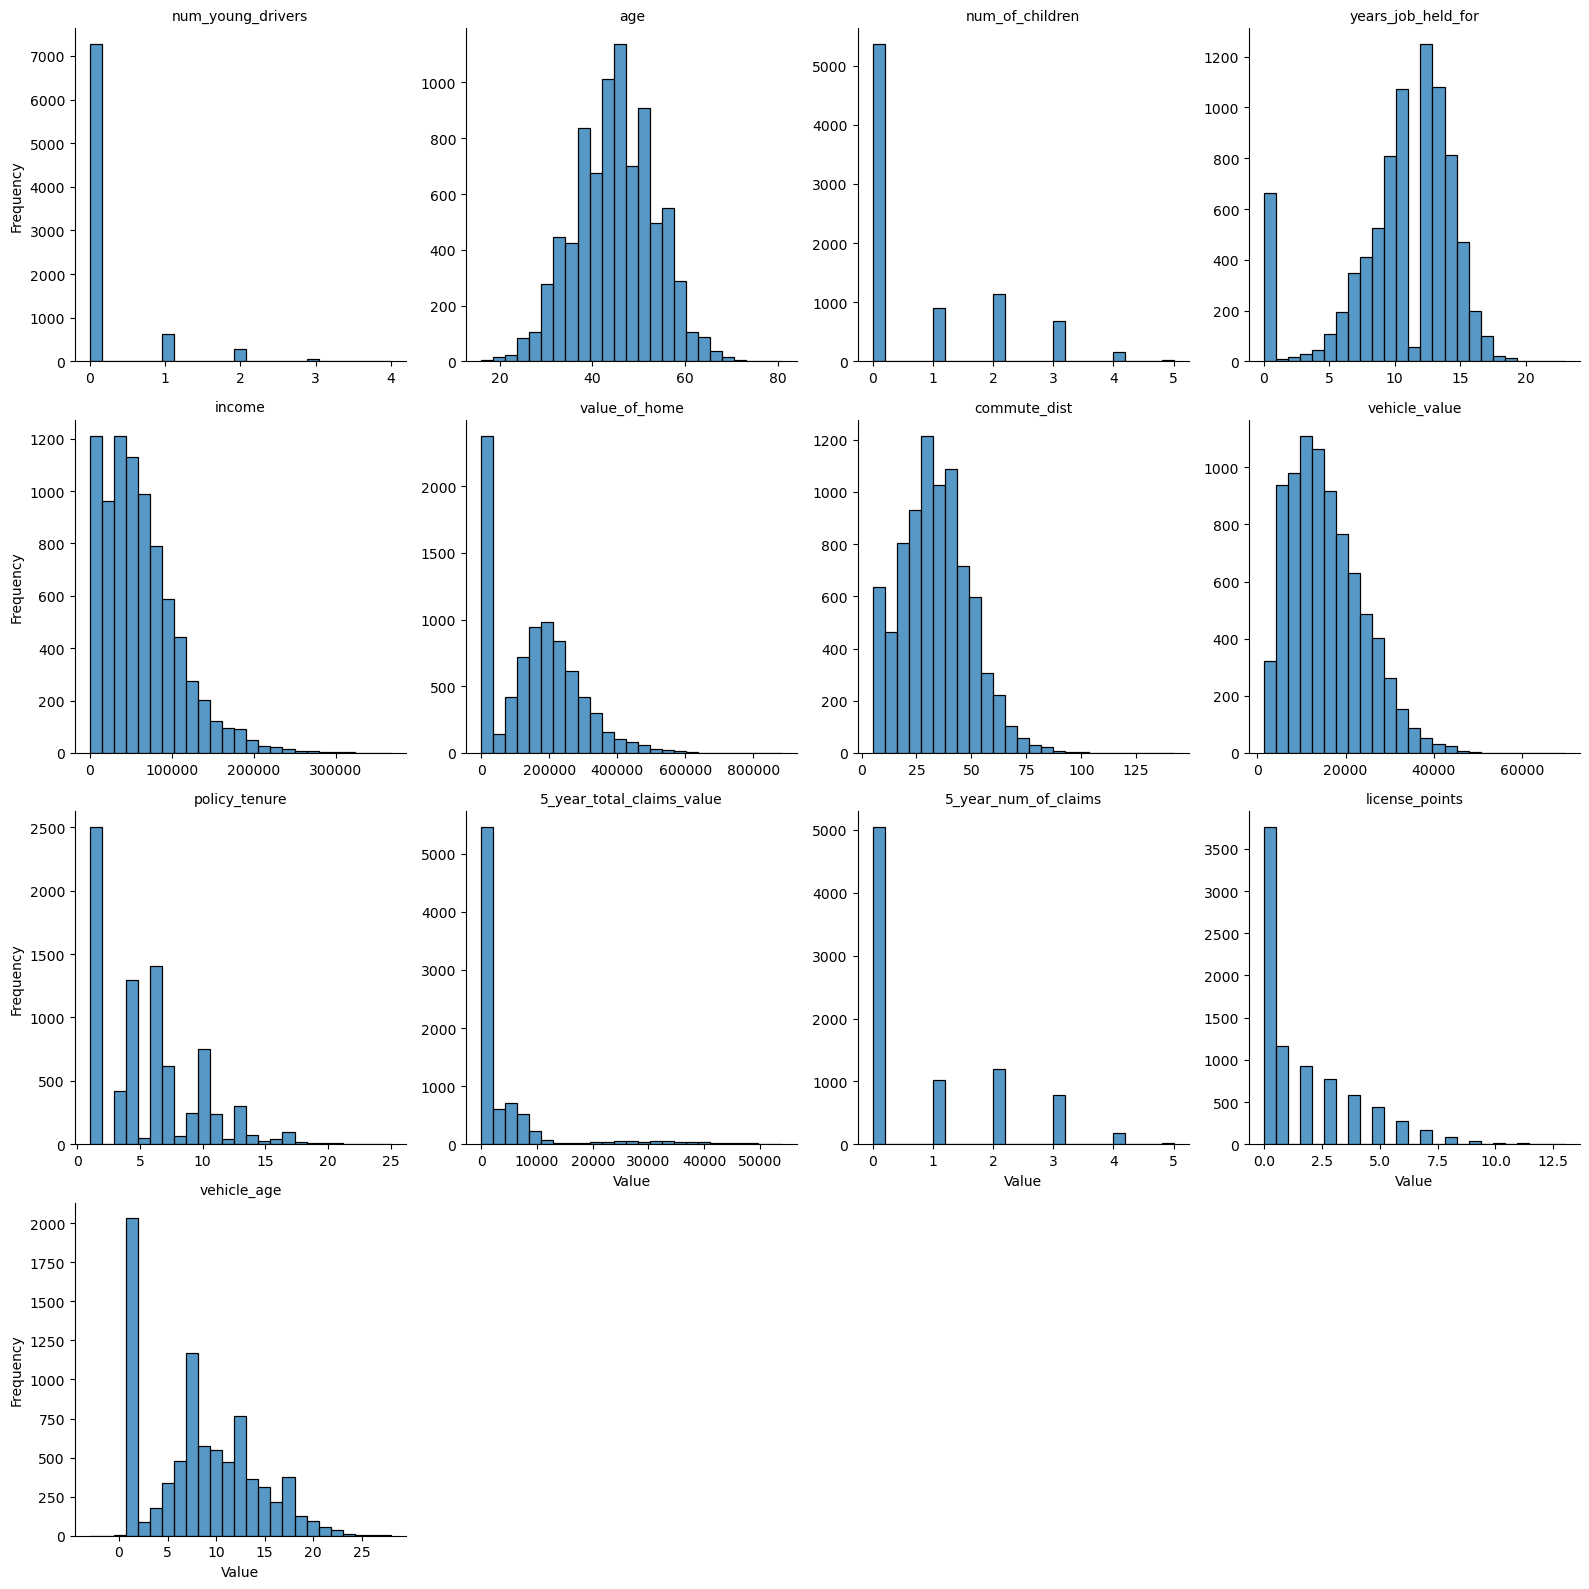

In [65]:
# Melt the DataFrame to long format
melted_X_train = X_train_cleaned[numerical_cols].melt(var_name='Column', value_name='Value')

# Create a FacetGrid
g = sns.FacetGrid(melted_X_train, col='Column', col_wrap=4, sharex=False, sharey=False, height=4)

# Map the sns.histplot to each facet
g.map(sns.histplot, 'Value', bins=25)

# Add titles and labels
g.set_axis_labels('Value', 'Frequency')
g.set_titles(col_template='{col_name}')

plt.tight_layout()
plt.show()

In [66]:
# Define features we right skew
skewed_features = ['income', 'value_of_home', 'commute_dist', 'vehicle_value', 'policy_tenure', 'license_points']

# Define function to apply log transform
def log_of_feature(data_df, skewed_features):
    data = data_df.copy()
    for feature in skewed_features:
        data[feature] = np.sqrt(data[feature])
    return data

# Apply the function to X_train
X_train_cleaned_log = log_of_feature(X_train_cleaned, skewed_features)

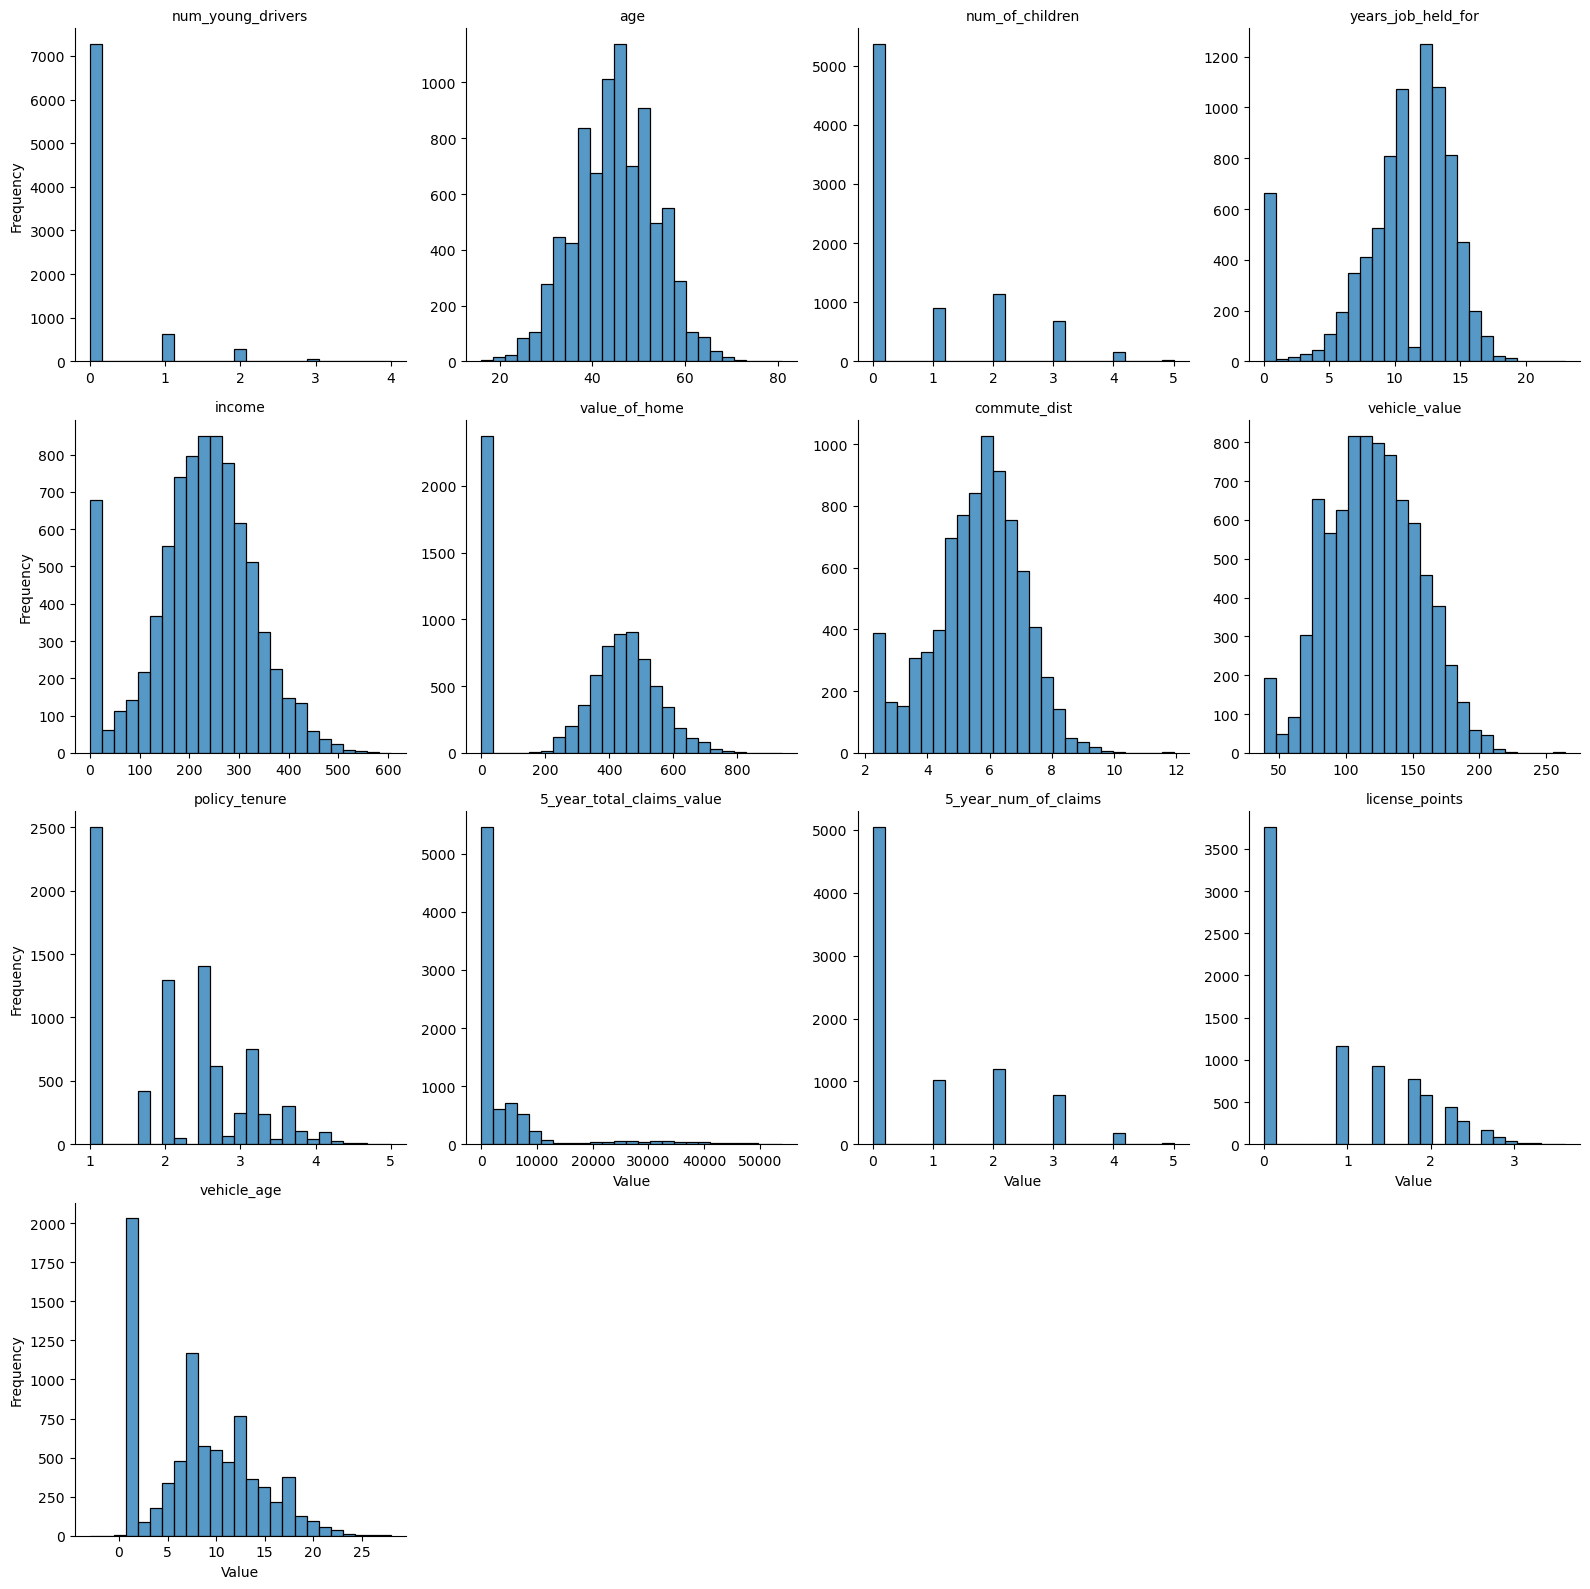

In [67]:

melted_X_train = X_train_cleaned_log[numerical_cols].melt(var_name='Column', value_name='Value')
g = sns.FacetGrid(melted_X_train, col='Column', col_wrap=4, sharex=False, sharey=False, height=4)
g.map(sns.histplot, 'Value', bins=25)
g.set_axis_labels('Value', 'Frequency')
g.set_titles(col_template='{col_name}')
plt.tight_layout()
plt.show()

In [68]:
# Assuming you have a non-transformed dataset named 'X_train_cleaned'
# and a log-transformed one named 'X_train_cleaned_log'

from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score, KFold

# --- Corrected Code ---

# Error 1: 'random_State' should be 'random_state' (lowercase 's')
xgb_boost_clf = XGBClassifier(random_state=42) 

# Assuming 'kf' is a defined KFold object, e.g., kf = KFold(n_splits=5)

# Logical Error: Use the non-transformed data for the first calculation
cv_scores = cross_val_score(xgb_boost_clf, X_train_cleaned, y_train, cv=kf) 

# Use the log-transformed data for the second calculation
cv_scores_log = cross_val_score(xgb_boost_clf, X_train_cleaned_log, y_train, cv=kf)

# Error 2: 'cv_score' should be 'cv_scores' (plural)
print(f'CV score without log transform: {cv_scores.mean()}')
print(f'CV score with log transform: {cv_scores_log.mean()}')

CV score without log transform: 0.6984223300970873
CV score with log transform: 0.6984223300970873


In [69]:
# Feature Scaling

In [70]:
from sklearn.preprocessing import StandardScaler

def scale_features(df, numerical_cols):
    scaler = StandardScaler()
    df[numerical_cols] = scaler.fit_transform(df[numerical_cols])
    return df


In [71]:
X_train_cleaned_scaled = scale_features(X_train_cleaned_log, numerical_cols)


In [72]:
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score

# Initialize classifier
xgb_boost_clf = XGBClassifier(random_state=42)

# Cross-validation without scaling
cv_scores = cross_val_score(xgb_boost_clf, X_train_cleaned, y_train, cv=kf)

# Cross-validation with scaling
cv_scores_scaled = cross_val_score(xgb_boost_clf, X_train_cleaned_scaled, y_train, cv=kf)

# Print mean scores
print(f'CV score without log/scale transform: {cv_scores.mean()}')
print(f'CV score with log/scale transform: {cv_scores_scaled.mean()}')


CV score without log/scale transform: 0.6984223300970873
CV score with log/scale transform: 0.6984223300970873


In [73]:
X_train_cleaned = X_train_cleaned_scaled.copy()

7. Model Pipeline

In [74]:
#7.1. Custom Transformers

In [75]:
# Custom transformer to drop specified columns
class ColumnDropper(BaseEstimator, TransformerMixin):
    def __init__(self, columns_to_drop):
        self.columns_to_drop = columns_to_drop
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X.drop(columns=self.columns_to_drop)
    
    def get_feature_names_out(self, input_features=None):
        return None

In [76]:
from sklearn.base import BaseEstimator, TransformerMixin
import numpy as np

class SqrtTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns_to_transform):
        self.columns_to_transform = columns_to_transform

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        X[self.columns_to_transform] = np.sqrt(X[self.columns_to_transform])
        return X

    def get_feature_names_out(self, input_features=None):
        return input_features


In [77]:
# Pipelines

In [78]:

from sklearn import set_config

# Set transformer output to df so we can reference columns names
set_config(transform_output='pandas')

In [79]:
# Define column dropper pipeline
cols_to_drop_pipeline = Pipeline([
    ('col_dropper', ColumnDropper(cols_to_drop))
])

skewed_features = ['income', 'value_of_home', 'commute_dist', 'vehicle_value', 'policy_tenure', 'license_points']

# Define numerical feature pipeline
num_pipeline = Pipeline([
    ('knn_imputer', KNNImputer(n_neighbors=2)),
    ('sqrt', SqrtTransformer(skewed_features)),
    ('scaler', StandardScaler()),
])

# Define rank of education levels
education_rank = [['<High School', 'High School', 'Bachelors', 'Masters', 'PhD']]

# Define ordinal categorical feature pipeline (highest_education feature)
cat_ord_pipeline = Pipeline([
    ('simple_imputer', SimpleImputer(strategy='most_frequent')),
    ('ord_encoder', OrdinalEncoder(categories=education_rank)),
])

# Define binary categorical feature pipeline
cat_bin_pipeline = Pipeline([
    ('simple_imputer', SimpleImputer(strategy='most_frequent')),
    ('binary_encoder', OrdinalEncoder()),
])

# Define one-hot categorical feature pipeline
cat_one_hot_pipeline = Pipeline([
    ('cat_simple_imputer', SimpleImputer(strategy='most_frequent')),
    ('one_hot_encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop='first')),
])

# Define preprocessing pipeline with a column transformer
preprocess_pipeline = ColumnTransformer([
    ('drop_features', cols_to_drop_pipeline, cols_to_drop),
    ('num', num_pipeline, numerical_cols),
    ('cat_ord', cat_ord_pipeline, cat_cols_ord),
    ('cat_bin', cat_bin_pipeline, cat_cols_bin),
    ('cat_one_hot', cat_one_hot_pipeline, cat_cols_one_hot),
])

In [80]:
X_train_prepared = preprocess_pipeline.fit_transform(X_train)

In [81]:
# Create df from processed data
X_train_prepared_df = pd.DataFrame(
    X_train_prepared,
    columns=preprocess_pipeline.get_feature_names_out(),
)

# Get names of new one-hot columns
one_hot_col_names = list(preprocess_pipeline.transformers_[4][1][1].get_feature_names_out(cat_cols_one_hot))

# Create list of all columns names
new_col_names = numerical_cols + cat_cols_ord + cat_cols_bin + one_hot_col_names

# Rename df columns
X_train_prepared_df.columns = new_col_names

# Reset index
X_train_prepared_df.reset_index(drop=True, inplace=True)

# Inspect df
X_train_prepared_df.head()

,num_young_drivers,age,num_of_children,years_job_held_for,income,value_of_home,commute_dist,vehicle_value,policy_tenure,5_year_total_claims_value,...,occupation_Home Maker,occupation_Lawyer,occupation_Manager,occupation_Professional,occupation_Student,vehicle_type_Panel Truck,vehicle_type_Pickup,vehicle_type_SUV,vehicle_type_Sports Car,vehicle_type_Van
0,-0.336651,-0.445163,-0.642753,0.140155,-0.488931,0.576396,0.763112,-0.106814,1.147030,-0.091375,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.336651,0.715035,-0.642753,0.626214,0.967924,0.831062,1.383037,0.324969,-1.236891,-0.462599,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,-0.336651,-0.213123,2.039815,-1.439538,-2.098652,-1.448999,0.763112,0.577944,-0.134387,-0.136286,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
3,-0.336651,-0.677202,0.251436,-1.074993,0.117943,0.718900,-0.204581,-1.054863,-0.134387,-0.462599,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
4,-0.336651,2.455332,-0.642753,1.112274,0.453553,0.911532,-0.015877,0.121361,0.361178,-0.462599,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [82]:
# Inspect manually created df
X_train_cleaned.head()

,num_young_drivers,age,num_of_children,years_job_held_for,income,value_of_home,commute_dist,vehicle_value,policy_tenure,5_year_total_claims_value,...,occupation_Home Maker,occupation_Lawyer,occupation_Manager,occupation_Professional,occupation_Student,vehicle_type_Panel Truck,vehicle_type_Pickup,vehicle_type_SUV,vehicle_type_Sports Car,vehicle_type_Van
0,-0.332668,1.409817,-0.643344,-2.563674,-0.375723,-1.452458,0.498062,-1.040804,1.139483,-0.461230,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,3.669060,-0.453096,2.054902,0.874127,-0.866152,0.037836,-0.479232,-1.159364,-0.142286,-0.461230,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,-0.332668,-1.850281,1.155487,0.383013,0.090791,0.424047,0.443522,-2.392885,-0.142286,0.161972,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,-0.332668,0.129064,0.256071,0.628570,0.258015,0.569484,-0.929180,0.845452,-1.245093,0.147137,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,-0.332668,-0.685960,-0.643344,-0.599216,1.093996,1.062875,-0.409978,-1.374057,-1.245093,-0.461230,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [ ]:
# Define the parameter grid for XGBoost
xgb_param_grid = {
    'n_estimators': randint(low=50, high=300),
    'learning_rate':uniform(0.01, 0.29),
    'max_depth': randint(low=1, high = 20),
    'subsample': uniform(0, 1),
    'colsample_bytree': uniform(0, 1),
    'min_child_weight': randint(low=1, high= 20),
    'reg_alpha': randint(low=0, high=100),
    'reg_lambda':randint(low=0, high=10),
    'gamma': uniform(0, 1),
}

# Initialize the XGBClassifier
xgb_model = XGBClassifier(random_state=42, eval_metric='error')

# Set up RandomizedSearchCV with F1 score as the evaluation metric
scorer = make_scorer(f1_score, average='weighted')
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=xgb_param_grid,
    n_iter=2000,  # Increased number of iterations
    scoring=scorer,
    cv=5,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

In [ ]:
# Fit the model using RandomizedSearchCV
random_search.fit(X_train_prepared, y_train)

# Print the best parameters and the best score
print("Best parameters found: ", random_search.best_params_)
print("Best cross-validation score: ", random_search.best_score_)

In [85]:
# Define the parameter grid with expanded ranges
xgb_param_grid_grid_search = {
    'n_estimators': [280, 290, 300],
    'max_depth': [6, 7, 8],
    'learning_rate': [0.03, 0.04, 0.05],
    'subsample': [0.45, 0.5, 0.55],
    'colsample_bytree': [0.5, 0.55, 0.6],
    'gamma': [0.05, 0.1, 0.15],
    'min_child_weight': [18],
    'reg_alpha': [1],
    'reg_lambda': [1],
}

# Initialize the XGBClassifier
xgb_model = XGBClassifier(random_state=42, eval_metric='error')

# Set up RandomizedSearchCV with F1 score as the evaluation metric
scorer = make_scorer(f1_score, average='weighted')
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=xgb_param_grid_grid_search,
    scoring=scorer,
    cv=5,
    verbose=1,
    n_jobs=-1
)

In [86]:
# Fit the model using RandomizedSearchCV
grid_search.fit(X_train_prepared, y_train)

# Print the best parameters and the best score
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation score: ", grid_search.best_score_)

Fitting 5 folds for each of 729 candidates, totalling 3645 fits
Best parameters found:  {'colsample_bytree': 0.6, 'gamma': 0.15, 'learning_rate': 0.05, 'max_depth': 8, 'min_child_weight': 18, 'n_estimators': 280, 'reg_alpha': 1, 'reg_lambda': 1, 'subsample': 0.55}
Best cross-validation score:  0.7859595716629257


In [ ]:

print(f'XGBoost model score (default hyperparameters): {cv_scores.mean()}')
print(f'XGBoost model score (tuned hyperparamters: {grid_search.best_score_}')

#9. Model Evaluation
It's now time to test the model with our test set.

In [ ]:
# Prepare test set using pipeline
X_test_prepared = preprocess_pipeline.fit_transform(X_test)

# Predict the y_test values using the best model from the grid search
y_pred = grid_search.best_estimator_.predict(X_test_prepared)

In [ ]:
f1_score(y_test, y_pred, average='weighted')

In [ ]:
# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix using ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title('Confusion Matrix on Training Data')

#10.Regression
10.1 Train/Test Sets
We can now look at the regression part of this project. We want to predict the total value of a claim, assuming a claim has been made. We start by creating the test/train sets, using only records where the claim value > 0.

In [ ]:
# Filter to only rows with a non-zero claim value
claim_data = data_df[data_df['new_claim_value'] > 0]

# Create clean copy of training data
X_reg = claim_data.copy()
y_reg = claim_data['new_claim_value']

# Drop the target feature
X_reg.drop(columns=['new_claim_value','is_claim', 'claim_value_cat'], inplace=True)

# Create train/test split
X_reg_train, X_reg_test, y_reg_train, y_reg_test = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)

In [ ]:
# Use the same pipeline as the classifier model to preprocess X train
X_reg_train_prepared = preprocess_pipeline.fit_transform(X_reg_train)

In [ ]:
#
10.2. Model Selection
We'll start by looking at the performance of some of the most popular regression models.

In [ ]:
regs = [
    ('Linear Regression', LinearRegression()),
    ('Logistic Regression', LogisticRegression(random_state=42, max_iter=25, solver='sag', tol=3)),
    ('SGD Regressor', SGDRegressor(random_state=42)),
    ('Decision Tree Regression ', DecisionTreeRegressor(random_state=42)),
    ('Random Forest', RandomForestRegressor(random_state=42)),
    ('KNN Model ', KNeighborsRegressor()),
    ('Support Vector Machines (SVM)', SVR(gamma=2, C=1)),
    ('XGBRegressor', XGBRegressor(random_state=42))
]

In [ ]:
# Create KFold object with 10 folds
reg_kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Dictionary to store results
reg_results = {}

# Evaluate each classifier using cross-validation
for reg_name, reg in regs:
    cv_rmses = -cross_val_score(reg, X_reg_train_prepared, y_reg_train, cv=reg_kf, scoring='neg_root_mean_squared_error')
    reg_results[reg_name] = cv_rmses

reg_cv_scores_df = pd.DataFrame(reg_results)

In [ ]:
# Plot scores
fig, ax = plt.subplots(figsize=(16, 8))
sns.boxplot(reg_cv_scores_df)

# Add axis labels
ax.set_xlabel('Regressor', fontsize=12)
ax.set_ylabel('CV RMSE', fontsize=12)
ax.set_title('Cross-Validation Scores for Different Regressors', fontsize=14)

In [ ]:
#10.3. Hyperparameter Optimisation
#As we did with the classification model, we'll first use random search to cover a large parameter space.

In [ ]:
# Define the parameter grid for SGDRegressor
reg_param_grid = {
    'penalty': ['l2', 'l1', 'elasticnet'],
    'alpha': uniform(0.0001, 0.01),
    'learning_rate': ['constant', 'invscaling'],
    'eta0': uniform(0.001, 0.1),
    'max_iter': randint(100, 1000),
    'tol': uniform(1e-6, 1e-3)
}

# Initialise the regressor
sgd_regressor = SGDRegressor(random_state=42)

# Create random search
reg_random_search = RandomizedSearchCV(
    estimator=sgd_regressor,
    param_distributions=reg_param_grid,
    n_iter=500,
    scoring='neg_mean_squared_error',
    cv=reg_kf,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

In [ ]:
# Fit the model using RandomizedSearchCV
random_search.fit(X_reg_train_prepared, y_reg_train)

score = np.sqrt(-random_search.best_score_)

# Print the best parameters and the best score
print("Best parameters found: ", random_search.best_params_)
print("Best cross-validation score: ", score)

In [ ]:
# Define the parameter grid for SGDRegressor
reg_param_grid_gs = {
    'penalty': ['l2', 'l1', 'elasticnet'],
    'alpha': [0.004, 0.008, 0.012],
    'learning_rate': ['invscaling'],
    'eta0': [0.001, 0.003, 0.005],
    'max_iter': [180, 200, 220],
    'tol': [1e-5, 1e-4, 1e-6]
}

# Initialise the regressor
sgd_regressor = SGDRegressor(random_state=42)

# Create random search
reg_grid_search = GridSearchCV(
    estimator=sgd_regressor,
    param_grid=reg_param_grid_gs,
    scoring='neg_mean_squared_error',
    cv=reg_kf,
    verbose=1,
    n_jobs=-1
)

In [ ]:
# Fit the model
reg_grid_search.fit(X_reg_train_prepared, y_reg_train)

reg_score = np.sqrt(-reg_grid_search.best_score_)

# Print the best parameters and the best score
print("Best parameters found: ", reg_grid_search.best_params_)
print("Best cross-validation score: ", reg_score)

10.4. Model Evaluation

In [ ]:
X_reg_test_prepared = preprocess_pipeline.fit_transform(X_reg_test)

y_reg_pred = reg_grid_search.best_estimator_.predict(X_reg_test_prepared)

mse = mean_squared_error(y_reg_test, y_reg_pred)
rmse = np.sqrt(mse)

mae = mean_absolute_error(y_reg_test, y_reg_pred)

print(f'RMSE: {rmse}')
print(f'MAE: {mae}')